In [2]:
# force geopandas to use shapely instead of pygeos
# import os
import pygeos
# os.environ['USE_PYGEOS'] = '0'

from shapely import wkt
# from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import gc
from datetime import datetime, timedelta

/Users/timtan/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Ingest Data

In [3]:
df = pd.read_csv("../data/data_2022_with_geom.csv")

In [4]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [5]:
df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

In [6]:
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42120 37.80002)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42120 37.80002)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42120 37.80002)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42120 37.80002)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42120 37.80002)


In [7]:
df['citation_day'] = df['Citation Issued DateTime'].dt.day_name()

In [8]:
# sort by date

df.sort_values('Citation Issued DateTime', inplace=True)

# Street Sections

In [9]:
# load and process streets information

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

In [10]:
street_df['segment_midpoint_x'] = street_df['Line'].apply(lambda line: line.centroid.x)
street_df['segment_midpoint_y'] = street_df['Line'].apply(lambda line: line.centroid.y)

In [11]:
street_df.head()

,CNN,Corridor,Limits,CNNRightLeft,BlockSide,FullName,WeekDay,FromHour,ToHour,Week1,Week2,Week3,Week4,Week5,Holidays,BlockSweepID,Line,segment_midpoint_x,segment_midpoint_y
0,9102000,Mission St,Julia St - 08th St,L,SouthEast,Thursday,Thu,2,6,1,1,1,1,1,1,1618894,"LINESTRING (-122.41241 37.77805, -122.41316 37...",-122.412786,37.777751
1,1191000,22nd St,Mission St - Bartlett St,L,South,Friday,Fri,6,8,1,1,1,1,1,0,1627862,"LINESTRING (-122.41875 37.75544, -122.41986 37...",-122.419303,37.755401
2,4331000,Congdon St,Maynard St - Silver Ave,L,East,Wednesday,Wed,11,13,1,1,1,1,1,0,1637394,"LINESTRING (-122.42602 37.72940, -122.42596 37...",-122.425994,37.729019
3,12043000,Sparta St,Ankeny St - Harkness Ave,R,West,Friday,Fri,12,15,1,1,1,1,1,0,1611118,"LINESTRING (-122.40355 37.71834, -122.40347 37...",-122.403592,37.717945
4,13148101,Van Ness Ave,Golden Gate Ave - Turk St,L,West,Tuesday,Tues,2,6,1,1,1,1,1,0,1598891,"LINESTRING (-122.42044 37.78103, -122.42055 37...",-122.420609,37.781479


In [12]:
street_df.head()

# copy line to a different column, because it gets deleted by the join
# Extract combined coordinates from geometry directly into separate columns
street_df[['X1', 'Y1']] = street_df['Line'].apply(lambda x: pd.Series([x.coords[0][0], x.coords[0][1]]))
street_df[['X2', 'Y2']] = street_df['Line'].apply(lambda x: pd.Series([x.coords[1][0], x.coords[1][1]]))

In [13]:
street_df.head()

,CNN,Corridor,Limits,CNNRightLeft,BlockSide,FullName,WeekDay,FromHour,ToHour,Week1,...,Week5,Holidays,BlockSweepID,Line,segment_midpoint_x,segment_midpoint_y,X1,Y1,X2,Y2
0,9102000,Mission St,Julia St - 08th St,L,SouthEast,Thursday,Thu,2,6,1,...,1,1,1618894,"LINESTRING (-122.41241 37.77805, -122.41316 37...",-122.412786,37.777751,-122.412413,37.778045,-122.413158,37.777457
1,1191000,22nd St,Mission St - Bartlett St,L,South,Friday,Fri,6,8,1,...,1,0,1627862,"LINESTRING (-122.41875 37.75544, -122.41986 37...",-122.419303,37.755401,-122.418748,37.755437,-122.419858,37.755366
2,4331000,Congdon St,Maynard St - Silver Ave,L,East,Wednesday,Wed,11,13,1,...,1,0,1637394,"LINESTRING (-122.42602 37.72940, -122.42596 37...",-122.425994,37.729019,-122.426025,37.729397,-122.425964,37.728641
3,12043000,Sparta St,Ankeny St - Harkness Ave,R,West,Friday,Fri,12,15,1,...,1,0,1611118,"LINESTRING (-122.40355 37.71834, -122.40347 37...",-122.403592,37.717945,-122.403555,37.718337,-122.403470,37.718197
4,13148101,Van Ness Ave,Golden Gate Ave - Turk St,L,West,Tuesday,Tues,2,6,1,...,1,0,1598891,"LINESTRING (-122.42044 37.78103, -122.42055 37...",-122.420609,37.781479,-122.420440,37.781031,-122.420552,37.781126


In [14]:
# Concatenate columns X1 and X2 #
street_df['Endpoint1'] = street_df['X1'].astype(str) + " " + street_df['Y1'].astype(str)
street_df['Endpoint2'] = street_df['X2'].astype(str) + " " + street_df['Y2'].astype(str)
#street_df['Endpoint1'] = pd.concat([street_df['X1'], df['Y1']], axis=1).apply(lambda x: ''.join(x), axis=1)
#street_df['Endpoint2'] = pd.concat([street_df['X2'], df['Y2']], axis=1).apply(lambda x: ''.join(x), axis=1)


# Remove excess columns
street_df = street_df.drop(['X1', 'X2', 'Y1', 'Y2'], axis=1)

In [15]:
street_df.head()

,CNN,Corridor,Limits,CNNRightLeft,BlockSide,FullName,WeekDay,FromHour,ToHour,Week1,...,Week3,Week4,Week5,Holidays,BlockSweepID,Line,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2
0,9102000,Mission St,Julia St - 08th St,L,SouthEast,Thursday,Thu,2,6,1,...,1,1,1,1,1618894,"LINESTRING (-122.41241 37.77805, -122.41316 37...",-122.412786,37.777751,-122.412413343787 37.778045328617,-122.413157691449 37.777457419935
1,1191000,22nd St,Mission St - Bartlett St,L,South,Friday,Fri,6,8,1,...,1,1,1,0,1627862,"LINESTRING (-122.41875 37.75544, -122.41986 37...",-122.419303,37.755401,-122.418747573844 37.75543693624,-122.419857942892 37.755365729245
2,4331000,Congdon St,Maynard St - Silver Ave,L,East,Wednesday,Wed,11,13,1,...,1,1,1,0,1637394,"LINESTRING (-122.42602 37.72940, -122.42596 37...",-122.425994,37.729019,-122.42602470434 37.72939698234,-122.42596370352 37.72864102171
3,12043000,Sparta St,Ankeny St - Harkness Ave,R,West,Friday,Fri,12,15,1,...,1,1,1,0,1611118,"LINESTRING (-122.40355 37.71834, -122.40347 37...",-122.403592,37.717945,-122.403554923986 37.718336652479,-122.403470376794 37.718196907433
4,13148101,Van Ness Ave,Golden Gate Ave - Turk St,L,West,Tuesday,Tues,2,6,1,...,1,1,1,0,1598891,"LINESTRING (-122.42044 37.78103, -122.42055 37...",-122.420609,37.781479,-122.420439517797 37.781030842108,-122.420552025357 37.781125672257


In [16]:
# spatial join - may need to reproject to flat geometry but seems like points are so close together that it would make a neglible difference. 
df_joined = gpd.sjoin_nearest(df, street_df, distance_col='dist', how='left')

/Users/timtan/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [17]:
# at this point we can delete unused dataframes
del df
del street_df

gc.collect()

0

In [18]:
df_joined.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,...,Week3,Week4,Week5,Holidays,BlockSweepID,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,7GXP111,23.0,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),...,1,1,1,1,1601828,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,7GXP111,23.0,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),...,1,1,1,1,1601833,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,7GXP111,23.0,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),...,1,1,1,1,1601838,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,7GXP111,23.0,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),...,1,1,1,1,1601818,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,7GXP111,23.0,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),...,1,1,1,1,1601843,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233


In [19]:
# drop duplicates from spatial join, still need to figure out why this happens
df_joined = df_joined.drop_duplicates(subset='Citation Number', keep="first")
assert df_joined.shape[0] == df_joined.shape[0]

In [20]:
df_joined['segment_id'] = df_joined['Corridor'] + ' from ' + df_joined['Limits']
df_joined.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,...,Week4,Week5,Holidays,BlockSweepID,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist,segment_id
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,7GXP111,23.0,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),...,1,1,1,1601828,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233,Great Hwy from John F Kennedy Dr - Lincoln Way
1119962,PD36997575,2022-01-01 02:45:00,V5204A,REG TABS,2251 GREENWICH,CA,8XOD966,341.0,02/06/2023 12:00:00 AM,POINT (-122.43672 37.79858),...,0,0,0,1638225,-122.436596,37.798382,-122.435772408102 37.798487191944,-122.43742040336 37.798277522307,0.000214,Pixley St from Fillmore St - Steiner St
394815,946687140,2022-01-01 07:00:00,V22500E,DRIVEWAY,665 EDDY ST,CA,7SCR930,110.0,02/05/2023 12:00:00 AM,POINT (-122.41862 37.78289),...,1,1,0,1630919,-122.418355,37.783206,-122.417528773794 37.783310889584,-122.419181703701 37.783101400225,0.000282,Eddy St from Larkin St - Polk St
273898,PD36969144,2022-01-01 08:16:00,V5204A,REG TABS,100 YACHT ROAD,CA,7NVL746,121.0,11/20/2022 12:00:00 AM,POINT (-122.44857 37.80643),...,0,0,0,1640391,-122.448085,37.804952,-122.447808303062 37.805103475266,-122.448010551529 37.805027693799,0.001507,Marina Blvd from Marina Blvd - Lyon St
548476,PD36969155,2022-01-01 08:45:00,V5204A,REG TABS,1551 BAY STREET,CA,8MTL483,121.0,02/01/2023 12:00:00 AM,POINT (-122.43249 37.80311),...,0,0,0,1612113,-122.432504,37.803162,-122.431679368855 37.803266736573,-122.433327956321 37.803056885178,0.000057,Bay St from Laguna St - Buchanan St


In [21]:
# let's just starting modeling on only Tuesdays
# Now stratify by days of the week.
df_joined['Day of Week'] = df_joined['Citation Issued DateTime'].dt.day_name()

# Let's also drop unnecessary columns, can add back later.
df_joined = df_joined.drop(['Week1', 'Week2', 'Week3', 'Week4', 'Week5', 'Vehicle Plate', 'Fine Amount',], axis=1)

In [22]:
df_joined.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Date Added,geom,citation_day,index_right,...,ToHour,Holidays,BlockSweepID,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist,segment_id,Day of Week
171693,PD36185715,2022-01-01 02:45:00,PK6.01G,NOPRK 10P6,1000 GREAT HIGHWAY,CA,03/15/2022 12:00:00 AM,POINT (-122.51054 37.76982),Saturday,18045,...,6,1,1601828,-122.510437,37.767239,-122.510925947378 37.770435676064,-122.51083358356 37.770303174044,0.000233,Great Hwy from John F Kennedy Dr - Lincoln Way,Saturday
1119962,PD36997575,2022-01-01 02:45:00,V5204A,REG TABS,2251 GREENWICH,CA,02/06/2023 12:00:00 AM,POINT (-122.43672 37.79858),Saturday,33963,...,11,0,1638225,-122.436596,37.798382,-122.435772408102 37.798487191944,-122.43742040336 37.798277522307,0.000214,Pixley St from Fillmore St - Steiner St,Saturday
394815,946687140,2022-01-01 07:00:00,V22500E,DRIVEWAY,665 EDDY ST,CA,02/05/2023 12:00:00 AM,POINT (-122.41862 37.78289),Saturday,37642,...,8,0,1630919,-122.418355,37.783206,-122.417528773794 37.783310889584,-122.419181703701 37.783101400225,0.000282,Eddy St from Larkin St - Polk St,Saturday
273898,PD36969144,2022-01-01 08:16:00,V5204A,REG TABS,100 YACHT ROAD,CA,11/20/2022 12:00:00 AM,POINT (-122.44857 37.80643),Saturday,2042,...,10,0,1640391,-122.448085,37.804952,-122.447808303062 37.805103475266,-122.448010551529 37.805027693799,0.001507,Marina Blvd from Marina Blvd - Lyon St,Saturday
548476,PD36969155,2022-01-01 08:45:00,V5204A,REG TABS,1551 BAY STREET,CA,02/01/2023 12:00:00 AM,POINT (-122.43249 37.80311),Saturday,17087,...,12,0,1612113,-122.432504,37.803162,-122.431679368855 37.803266736573,-122.433327956321 37.803056885178,0.000057,Bay St from Laguna St - Buchanan St,Saturday


In [23]:
df_joined = df_joined[df_joined['Day of Week'] == "Tuesday"]

In [24]:
df_joined['segment_id'] = df_joined['segment_id'].astype(str)

# Replace double spaces with single spaces in column
df_joined['segment_id'] = df_joined['segment_id'].str.replace('  ', ' ')

# adding an hour + minute column
df_joined['hour'] = df_joined['Citation Issued DateTime'].dt.hour
df_joined['minute'] = df_joined['Citation Issued DateTime'].dt.minute
df_joined['date'] = df_joined['Citation Issued DateTime'].dt.date

# sort by date time.
df_joined = df_joined.sort_values('Citation Issued DateTime')

df_joined.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Date Added,geom,citation_day,index_right,...,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist,segment_id,Day of Week,hour,minute,date
287268,PD37009420,2022-01-04 00:00:00,V5204A,REG TABS,101 GROVE STREET,CA,09/11/2022 12:00:00 AM,POINT (-122.41871 37.77812),Tuesday,3131,...,-122.418925,37.777870,-122.418138568487 37.777970663296,-122.419711625489 37.777770152091,0.000222,Lech Walesa St from Polk St - Van Ness Ave,Tuesday,0,0,2022-01-04
559229,946786750,2022-01-04 00:04:00,TRC7.2.22,STR CLEAN,465 CLEMENTINA ST,CA,04/10/2022 12:00:00 AM,POINT (-122.40532 37.77953),Tuesday,9258,...,-122.405042,37.779821,-122.403920881443 37.780699049213,-122.4061628586 37.778942761943,0.000053,Clementina St from 05th St - 06th St,Tuesday,0,4,2022-01-04
154949,946974453,2022-01-04 00:05:00,TRC7.2.22,STR CLEAN,4 BLUXOME ST,CA,03/02/2022 12:00:00 AM,POINT (-122.39590 37.77771),Tuesday,4753,...,-122.396137,37.778013,-122.396530638005 37.778326831808,-122.39574395441 37.777698420876,0.000094,04th St from Brannan St - Bluxome St,Tuesday,0,5,2022-01-04
503338,946977544,2022-01-04 00:05:00,TRC7.2.22,STR CLEAN,80 STEVENSON ST,CA,01/13/2022 12:00:00 AM,POINT (-122.40043 37.78922),Tuesday,33906,...,-122.400081,37.789393,-122.399350054812 37.789970504635,-122.40081230267 37.788815496643,0.000077,Stevenson St from Ecker St - 02nd St,Tuesday,0,5,2022-01-04
804604,946786761,2022-01-04 00:06:00,TRC7.2.22,STR CLEAN,410 CLEMENTINA ST,CA,02/22/2022 12:00:00 AM,POINT (-122.40422 37.78055),Tuesday,9258,...,-122.405042,37.779821,-122.403920881443 37.780699049213,-122.4061628586 37.778942761943,0.000071,Clementina St from 05th St - 06th St,Tuesday,0,6,2022-01-04


# Starting pathing alogrithm

In [25]:
# gets intersecting streets given steet segment
def get_intersect_st(df, segment_id):
    df.head()
    # getting endpoints of initial condition
    Endpoint1 = df[df['segment_id'] == segment_id]['Endpoint1'].iloc[0]
    Endpoint2 = df[df['segment_id'] == segment_id]['Endpoint2'].iloc[0]

    # now we need to get the segment_id's of streets that share the same endpoints
    unique_segments1 = df[(df['Endpoint1'] == Endpoint1) | (df['Endpoint1'] == Endpoint2)]['segment_id'].unique()
    unique_segments2 = df[(df['Endpoint2'] == Endpoint1) | (df['Endpoint2'] == Endpoint2)]['segment_id'].unique()

    # now return a concatonated list of segments into one vector
    unique_segments = np.unique(np.concatenate((unique_segments1, unique_segments2)))

    # Remove current segment from intersection
    unique_segments = unique_segments[unique_segments != segment_id]

    return(unique_segments)


# calling get_intersect_st
intersections = get_intersect_st(df_joined, 'Hayes St from Franklin St - Gough St')

# given intersections, get the street with the next ticket.
def next_section_ticketed(df, segment_id, intersections):
    
    # get a vector of date times
    current_dates = df[df['segment_id'] == segment_id]['Citation Issued DateTime']
    current_dates = list(current_dates)

    # now let's add 6 minutes to current times.
    future_time = [c_d + timedelta(minutes=5) for c_d in current_dates]

    # now create a new df that's just filtered to intersecting streets
    df_int = df[df['segment_id'].isin(intersections)]

    # Now filter such that it's bascially 5 minutes after date times
    # we can probably only do this iteratively.
    next_street_df = pd.DataFrame()
    for i in range(len(current_dates)):
        next_street_df = pd.concat([next_street_df, df_int[(df_int['Citation Issued DateTime'] >= current_dates[i]) 
                                                           & (df_int['Citation Issued DateTime'] <= future_time[i])]], axis = 0)

    return(next_street_df)

next_street = next_section_ticketed(df_joined, 'Hayes St from Franklin St - Gough St', intersections)
next_street.head(5)

# so now the current problem is that there is a fork in the road between two streeets.

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Date Added,geom,citation_day,index_right,...,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist,segment_id,Day of Week,hour,minute,date
891862,946931042,2022-01-18 07:25:00,V5200,NO PLATES,431 HAYES ST,CA,04/28/2022 12:00:00 AM,POINT (-122.42351 37.77673),Tuesday,6985,...,-122.423746,37.776786,-122.422978149539 37.776883526732,-122.424513700037 37.77668755581,0.000082,Hayes St from Gough St - Octavia St,Tuesday,7,25,2022-01-18
380083,947312251,2022-02-01 14:32:00,TRC7.2.23A,METER DTN,307 FRANKLIN ST,CA,02/10/2022 12:00:00 AM,POINT (-122.42142 37.77719),Tuesday,4233,...,-122.421378,37.777325,-122.421330431315 37.777090972688,-122.421426124768 37.777559630915,0.000065,Franklin St from Hayes St - Ivy St,Tuesday,14,32,2022-02-01
842658,947846266,2022-02-08 17:34:00,TRC7.2.23A,METER DTN,303 FRANKLIN ST,CA,05/23/2022 12:00:00 AM,POINT (-122.42141 37.77715),Tuesday,4233,...,-122.421378,37.777325,-122.421330431315 37.777090972688,-122.421426124768 37.777559630915,0.000066,Franklin St from Hayes St - Ivy St,Tuesday,17,34,2022-02-08
842658,947846266,2022-02-08 17:34:00,TRC7.2.23A,METER DTN,303 FRANKLIN ST,CA,05/23/2022 12:00:00 AM,POINT (-122.42141 37.77715),Tuesday,4233,...,-122.421378,37.777325,-122.421330431315 37.777090972688,-122.421426124768 37.777559630915,0.000066,Franklin St from Hayes St - Ivy St,Tuesday,17,34,2022-02-08
297110,947846270,2022-02-08 17:35:00,TRC7.2.23A,METER DTN,321 FRANKLIN ST,CA,03/16/2022 12:00:00 AM,POINT (-122.42146 37.77743),Tuesday,4233,...,-122.421378,37.777325,-122.421330431315 37.777090972688,-122.421426124768 37.777559630915,0.000057,Franklin St from Hayes St - Ivy St,Tuesday,17,35,2022-02-08


                            segment_id  count
0   Franklin St from Hayes St - Ivy St      3
1  Hayes St from Gough St - Octavia St      4


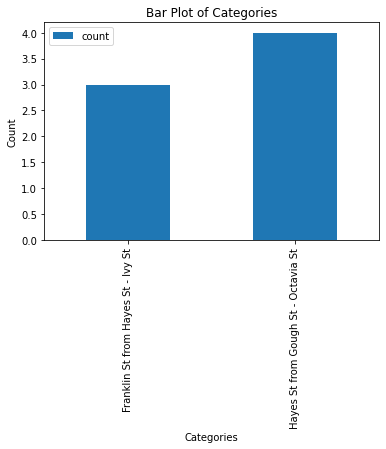

In [26]:
def plot_next_st(next_st_df):
    # now let's filter by unique date time.
    next_street_counts = next_st_df.groupby(['date'])['segment_id'].value_counts()
    next_street_counts = next_street_counts.groupby(['segment_id']).size().reset_index(name='count')
    print(next_street_counts)

    next_street_counts.plot.bar(x='segment_id', y='count')

    # title
    plt.title('Bar Plot of Categories')

    # axis labels
    plt.xlabel('Categories')
    plt.ylabel('Count')

    plt.show()

plot_next_st(next_street)

This part of hayes (let's call it street A) is sandwiched between Franklin to the west and Gough to the east. Both these streets are to the west with Ivy going north and Ocavia going west. So which street did enforcement go down? It could be the case that they went up Ivy, then back down to Octavia. So let's check that.

                           segment_id  count
0  Franklin St from Ivy St - Grove St      2
1  Ivy St from Franklin St - Gough St      3


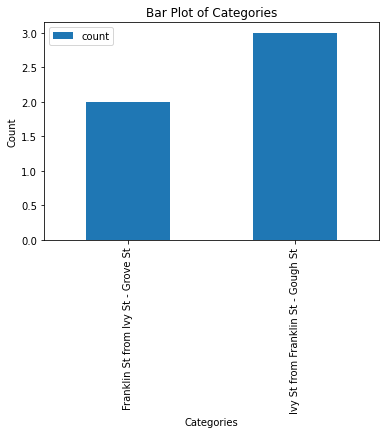

In [27]:
segment2 = 'Franklin St from Hayes St - Ivy St'
# calling get_intersect_st
intersections2 = get_intersect_st(df_joined, segment2)
next_street2 = next_section_ticketed(df_joined, segment2, intersections2)

next_street2.head(50)

plot_next_st(next_street2)

                             segment_id  count
0       Gough St from Hayes St - Ivy St      2
1  Hayes St from Franklin St - Gough St      2
2  Hayes St from Octavia St - Laguna St     12
3     Octavia St from Hayes St - Ivy St      1


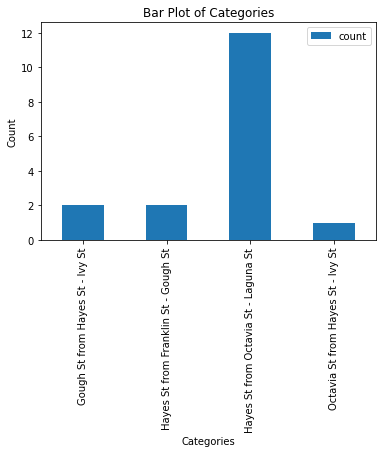

In [28]:
segment3 = 'Hayes St from Gough St - Octavia St'

# calling get_intersect_st
intersections3 = get_intersect_st(df_joined, segment3)
next_street3 = next_section_ticketed(df_joined, segment3, intersections3)

next_street3.head(50)

plot_next_st(next_street3)

# Testing code before putting it into function  pls ignore

In [29]:
segment_id = 'Hayes St from Franklin St - Gough St'
segment_id2 = 'Hayes St from Van Ness Ave - Franklin St'

Endpoint1 = '-122.421330431315 37.777090972688'
Endpoint2 = '-122.422978149539 37.776883526732'

unique_segments1 = df_joined[(df_joined['Endpoint1'] == Endpoint1) | (df_joined['Endpoint1'] == Endpoint2)]['segment_id'].unique()
unique_segments2 = df_joined[(df_joined['Endpoint2'] == Endpoint1) | (df_joined['Endpoint2'] == Endpoint2)]['segment_id'].unique()

In [30]:
print(unique_segments1)

['Hayes St from Gough St - Octavia St'
 'Hayes St from Franklin St - Gough St' 'Gough St from Hayes St - Ivy St'
 'Franklin St from Hayes St - Ivy St']


In [31]:
print(unique_segments2)

['Hayes St from Franklin St - Gough St'
 'Gough St from Linden St - Hayes St'
 'Franklin St from Linden St - Hayes St'
 'Hayes St from Van Ness Ave - Franklin St']


In [32]:
df_joined[df_joined['segment_id'] == segment_id].head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Date Added,geom,citation_day,index_right,...,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist,segment_id,Day of Week,hour,minute,date
232629,946770720,2022-01-04 13:08:00,TRC7.2.23B,MTR OUT DT,323 HAYES ST,CA,01/31/2022 12:00:00 AM,POINT (-122.42163 37.77697),Tuesday,2647,...,-122.422154,37.776987,-122.421330431315 37.777090972688,-122.422978149539 37.776883526732,0.000081,Hayes St from Franklin St - Gough St,Tuesday,13,8,2022-01-04
624794,946931031,2022-01-18 07:22:00,V5200,NO PLATES,305 HAYES ST,CA,10/24/2022 12:00:00 AM,POINT (-122.42144 37.77699),Tuesday,2647,...,-122.422154,37.776987,-122.421330431315 37.777090972688,-122.422978149539 37.776883526732,0.000081,Hayes St from Franklin St - Gough St,Tuesday,7,22,2022-01-18
509771,947312240,2022-02-01 14:29:00,TRC7.2.23B,MTR OUT DT,315 HAYES ST,CA,02/15/2022 12:00:00 AM,POINT (-122.42155 37.77698),Tuesday,2647,...,-122.422154,37.776987,-122.421330431315 37.777090972688,-122.422978149539 37.776883526732,0.000081,Hayes St from Franklin St - Gough St,Tuesday,14,29,2022-02-01
589802,947846222,2022-02-08 17:27:00,TRC7.2.23B,MTR OUT DT,321 HAYES ST,CA,04/03/2022 12:00:00 AM,POINT (-122.42161 37.77697),Tuesday,2647,...,-122.422154,37.776987,-122.421330431315 37.777090972688,-122.422978149539 37.776883526732,0.000081,Hayes St from Franklin St - Gough St,Tuesday,17,27,2022-02-08
509766,947846233,2022-02-08 17:29:00,TRC7.2.23B,MTR OUT DT,315 HAYES ST,CA,03/30/2022 12:00:00 AM,POINT (-122.42155 37.77698),Tuesday,2647,...,-122.422154,37.776987,-122.421330431315 37.777090972688,-122.422978149539 37.776883526732,0.000081,Hayes St from Franklin St - Gough St,Tuesday,17,29,2022-02-08


In [33]:
df_joined[df_joined['segment_id'] == segment_id2]

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Date Added,geom,citation_day,index_right,...,segment_midpoint_x,segment_midpoint_y,Endpoint1,Endpoint2,dist,segment_id,Day of Week,hour,minute,date
1082395,953935640,2022-08-09 01:15:00,TRC7.2.22,STR CLEAN,215 HAYES ST,CA,01/29/2023 12:00:00 AM,POINT (-122.41995 37.77718),Tuesday,2233,...,-122.420512,37.777195,-122.419693565872 37.777299856161,-122.421330431315 37.777090972688,0.000083,Hayes St from Van Ness Ave - Franklin St,Tuesday,1,15,2022-08-09
1054236,957170266,2022-11-22 14:11:00,TRC7.2.40,PRK PROHIB,250 HAYES ST,CA,12/29/2022 12:00:00 AM,POINT (-122.42042 37.77727),Tuesday,2233,...,-122.420512,37.777195,-122.419693565872 37.777299856161,-122.421330431315 37.777090972688,0.000063,Hayes St from Van Ness Ave - Franklin St,Tuesday,14,11,2022-11-22
1031661,959084604,2023-01-24 08:47:00,TRC7.2.22,STR CLEAN,230 HAYES ST,CA,02/19/2023 12:00:00 AM,POINT (-122.42016 37.77730),Tuesday,2233,...,-122.420512,37.777195,-122.419693565872 37.777299856161,-122.421330431315 37.777090972688,0.000062,Hayes St from Van Ness Ave - Franklin St,Tuesday,8,47,2023-01-24
